In [1]:
import time
from collections.abc import Callable

import evaluate
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F  # noqa: N812
from tokenizers import Tokenizer, decoders, normalizers
from tokenizers.models import WordPiece
from tokenizers.normalizers import NFD, Lowercase
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.processors import TemplateProcessing
from tokenizers.trainers import WordPieceTrainer
from torch import Tensor, nn
from tqdm import tqdm

import datasets


### Data processing

In [2]:
PARENT_DIR = "."

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    # for Apple chips
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)

cuda


In [3]:
# dataset = datasets.load_dataset("Helsinki-NLP/opus-100", "de-en")
dataset = datasets.load_from_disk(f"{PARENT_DIR}/datasets/iwslt_de_en_dataset")

In [5]:
train_data, valid_data, test_data = (
    dataset["train"],
    dataset["validation"],
    dataset["test"],
)

MAX_NUM_SAMPLES = None
if MAX_NUM_SAMPLES is not None:
    train_data = train_data.take(MAX_NUM_SAMPLES)

In [6]:
def craete_tokenizer(max_vocab_size: int = 4000) -> tuple[Tokenizer, WordPieceTrainer]:
    tokenizer = Tokenizer(WordPiece(unk_token="<UNK>"))  # noqa: S106
    tokenizer.normalizer = normalizers.Sequence([NFD(), Lowercase()])
    tokenizer.pre_tokenizer = Whitespace()
    tokenizer.post_processor = TemplateProcessing(
        single="<BOS> $A <EOS>",
        special_tokens=[
            ("<BOS>", 1),
            ("<EOS>", 2),
        ],
    )
    tokenizer.decoder = decoders.WordPiece()
    trainer = WordPieceTrainer(vocab_size=max_vocab_size,
                               special_tokens=["<UNK>", "<BOS>", "<EOS>", "<PAD>"])

    return tokenizer, trainer

def batch_iterator(batch_size: int, data: datasets.Dataset, key: str) -> list[str]:
    for i in range(0, len(data), batch_size):
        data_batch = data[i : i + batch_size]["translation"]
        data_key = [x[key] for x in data_batch]
        yield data_key

In [7]:
src_lang, src_lang_trainer = craete_tokenizer()
tgt_lang, tgt_lang_trainer = craete_tokenizer()

src_lang.train_from_iterator(batch_iterator(256, train_data, "de"), src_lang_trainer)
tgt_lang.train_from_iterator(batch_iterator(256, train_data, "en"), tgt_lang_trainer)

src_lang.save(f"{PARENT_DIR}/de_tokenizer")
tgt_lang.save(f"{PARENT_DIR}/en_tokenizer")

In [8]:
def tokenize_example(example: dict[str, str],
                     en_tokenizer: Tokenizer,
                     de_tokenizer: Tokenizer,
                     max_length: int) -> dict[str, list[str | int]]:
    en_encoded = en_tokenizer.encode(example["translation"]["en"])
    de_encoded = de_tokenizer.encode(example["translation"]["de"])

    return {"en_tokens": en_encoded.tokens[:max_length],
            "de_tokens": de_encoded.tokens[:max_length],
            "en_ids": en_encoded.ids[:max_length],
            "de_ids": de_encoded.ids[:max_length]}

max_length = 128
sos_token = "<BOS>"  # noqa: S105
eos_token = "<EOS>"  # noqa: S105

fn_kwargs = {
    "en_tokenizer": tgt_lang,
    "de_tokenizer": src_lang,
    "max_length": max_length,
}

train_data = train_data.map(tokenize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(tokenize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(tokenize_example, fn_kwargs=fn_kwargs)

train_data.save_to_disk(f"{PARENT_DIR}/train_data_{max_length}")
valid_data.save_to_disk(f"{PARENT_DIR}/valid_data_{max_length}")
test_data.save_to_disk(f"{PARENT_DIR}/test_data_{max_length}")

train_data = datasets.load_from_disk(f"{PARENT_DIR}/train_data_{max_length}")
valid_data = datasets.load_from_disk(f"{PARENT_DIR}/valid_data_{max_length}")
test_data = datasets.load_from_disk(f"{PARENT_DIR}/test_data_{max_length}")

Map:   0%|          | 0/206112 [00:00<?, ? examples/s]

Map:   0%|          | 0/888 [00:00<?, ? examples/s]

Map:   0%|          | 0/8079 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/206112 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/888 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/8079 [00:00<?, ? examples/s]

In [9]:
print(f"Vocab size src: {src_lang.get_vocab_size()}")
print(f"Vocab size tgt: {tgt_lang.get_vocab_size()}")

Vocab size src: 4000
Vocab size tgt: 4000


In [10]:
print(src_lang.decode(train_data[2]["de_ids"]))
print(tgt_lang.decode(train_data[2]["en_ids"]))

ich bin wirklich begeistert von dieser konferenz, und ich danke ihnen allen für die vielen netten kommentare zu meiner rede vorgestern abend.
i have been blown away by this conference, and i want to thank all of you for the many nice comments about what i had to say the other night.


In [11]:
data_type = "torch"
format_columns = ["en_ids", "de_ids"]

train_data = train_data.with_format(
    type=data_type, columns=format_columns, output_all_columns=True
    )

valid_data = valid_data.with_format(
    type=data_type, columns=format_columns, output_all_columns=True
)

test_data = test_data.with_format(
    type=data_type, columns=format_columns, output_all_columns=True
)

In [12]:
def get_collate_fn(pad_index: int) -> Callable[[dict], dict]:
    def collate_fn(batch: dict) -> dict[str, int]:
        batch_en_ids = [example["en_ids"] for example in batch]
        batch_de_ids = [example["de_ids"] for example in batch]
        batch_en_ids = nn.utils.rnn.pad_sequence(batch_en_ids, padding_value=pad_index)
        batch_de_ids = nn.utils.rnn.pad_sequence(batch_de_ids, padding_value=pad_index)
        return {
            "en_ids": batch_en_ids,
            "de_ids": batch_de_ids,
        }

    return collate_fn

def get_data_loader(dataset: datasets.Dataset, batch_size: int, pad_index: int, *,
                    shuffle: bool = True, pin_memory: bool = False) -> torch.utils.data.DataLoader:
    collate_fn = get_collate_fn(pad_index)
    return torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
        pin_memory=pin_memory,
    )

batch_size = 64

train_data_loader = get_data_loader(train_data, batch_size, tgt_lang.token_to_id("<PAD>"))
valid_data_loader = get_data_loader(valid_data, batch_size, tgt_lang.token_to_id("<PAD>"))
test_data_loader = get_data_loader(test_data, batch_size, tgt_lang.token_to_id("<PAD>"))

### Model

In [13]:
class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_dim: int, num_heads: int, dropout_ratio: float = 0.1):
        if hidden_dim % num_heads != 0:
            msg = "hidden_dim must be divisible by num_heads"
            raise ValueError(msg)

        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.head_dim = hidden_dim // num_heads

        self.fc_q = nn.Linear(hidden_dim, hidden_dim)
        self.fc_k = nn.Linear(hidden_dim, hidden_dim)
        self.fc_v = nn.Linear(hidden_dim, hidden_dim)

        self.out = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_ratio)

        self.scaling = 1 / (self.head_dim ** .5)

    def forward(self, q: Tensor, k: Tensor, v: Tensor, mask: Tensor = None) -> Tensor:
        """
        Inputs
            q: query of size (batch_size, seq_length, hidden_dim)
            k: query of size (batch_size, seq_length, hidden_dim)
            v: query of size (batch_size, seq_length, hidden_dim)
            mask: optional mask of size (batch_size, 1, 1, seq_length)
                  or (batch_size, 1, seq_length, seq_length)
        Outputs
            attention weighted embedding vectors of size (batch_size, seq_length, hidden_dim)
        """
        # all Q, K, V are of shape (batch_size, seq_length, hidden_dim)
        Q = self.fc_q(q)
        K = self.fc_k(k)
        V = self.fc_v(v)

        batch_size, seq_length, _ = Q.size()

        # all Q, K, V are of shape (batch_size, num_heads, seq_length, head_dim)
        Q = Q.view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

        # energy.shape (batch_size, num_heads, seq_length, seq_length)
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) * self.scaling  # type: Tensor

        if mask is not None:
            energy = energy.masked_fill(mask == 0, -torch.inf)

        # attention.shape (batch_size, num_heads, seq_length, seq_length)
        attention = energy.softmax(dim=-1)
        attention = self.dropout(attention)

        # x.shape (batch_size, num_heads, seq_length, head_dim)
        x = torch.matmul(attention, V)

        # x.shape (batch_size, seq_length, num_heads, head_dim)
        x = x.permute(0, 2, 1, 3)

        # x.shape (batch_size, seq_length, hidden_dim)
        x = x.reshape(batch_size, seq_length, self.hidden_dim)

        # x.shape (batch_size, seq_length, hidden_dim)
        x = self.out(x)

        return x

In [14]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, hidden_dim: int, ff_dim: int, dropout_ratio: float = 0.1):
        super().__init__()

        self.fc_1 = nn.Linear(hidden_dim, ff_dim)
        self.fc_2 = nn.Linear(ff_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, x) -> Tensor:
        # x.shape (batch_size, seq_length, emb_dim)
        x = self.fc_1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc_2(x)
        return x

In [15]:
class EncoderLayer(nn.Module):
    def __init__(self, hidden_dim: int, num_heads: int, ff_dim:int, dropout_ratio: float = 0.1):
        super().__init__()

        self.norm_1 = nn.LayerNorm(hidden_dim)
        self.norm_2 = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout_ratio)
        self.ff = PositionWiseFeedForward(hidden_dim=hidden_dim, ff_dim=ff_dim)

        self.mha = MultiHeadAttention(hidden_dim=hidden_dim,
                                      num_heads=num_heads,
                                      dropout_ratio=dropout_ratio)

    def forward(self, src: Tensor, mask: Tensor | None = None) -> Tensor:
        """
        Inputs
            input of size (batch_size, seq_length, hidden_dim)
            mask of size (batch_size, 1, 1, seq_length)
        Outputs
            (batch_size, seq_length, hidden_dim)
        """
        # x1.shape (batch_size, seq_length, hidden_dim)
        x1 = self.mha(src, src, src, mask=mask)  # type: Tensor
        x1 = self.norm_1(self.dropout(x1) + src)

        # x2.shape (batch_size, seq_length, hidden_dim)
        x2 = self.ff(x1)
        x2 = self.norm_2(x1 + self.dropout(x2))

        return x2

In [16]:
# TODO: remove scaling in encoder?

In [17]:
class Encoder(nn.Module):
    def __init__(self, vocab_size: int, hidden_dim: int,
                 num_heads: int, num_layers: int, ff_dim: int, max_seq_length: int,
                 device: torch.device, dropout_ratio: float = 0.1):
        super().__init__()

        self.device = device
        self.scaling = hidden_dim ** (0.5)

        self.token_embedding = nn.Embedding(vocab_size, hidden_dim)
        self.positional_embedding = nn.Embedding(max_seq_length, hidden_dim)
        self.dropout = nn.Dropout(dropout_ratio)

        self.layers = nn.ModuleList([EncoderLayer(hidden_dim=hidden_dim,
                                                  num_heads=num_heads, ff_dim=ff_dim,
                                                  dropout_ratio=dropout_ratio)
                                     for _ in range(num_layers)])

    def forward(self, src: Tensor, mask: Tensor | None = None) -> Tensor:
        """
        Inputs
            input of shape (batch_size, seq_legth)
        Outputs
            encoded sequence of shape (batch_size, seq_legth, hidden_dim)
        """
        batch_size, seq_length = src.size()
        positions = torch.arange(0, seq_length).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        # x.shape (batch_size, seq_legth, hidden_dim)
        x = self.token_embedding(src) * self.scaling + self.positional_embedding(positions)
        x = self.dropout(x)

        for layer in self.layers:
            # x.shape (batch_size, seq_legth, hidden_dim)
            x = layer(x, mask)

        return x

In [18]:
class DecoderLayer(nn.Module):
    def __init__(self, hidden_dim: int, num_heads: int,
                 ff_dim:int, dropout_ratio: float = 0.1):
        super().__init__()

        self.norm_1 = nn.LayerNorm(hidden_dim)
        self.norm_2 = nn.LayerNorm(hidden_dim)
        self.norm_3 = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout_ratio)
        self.num_heads = num_heads
        self.ff = PositionWiseFeedForward(hidden_dim=hidden_dim, ff_dim=ff_dim)

        self.self_attention = MultiHeadAttention(hidden_dim=hidden_dim,
                                                 num_heads=num_heads,
                                                 dropout_ratio=dropout_ratio)

        self.enc_attention = MultiHeadAttention(hidden_dim=hidden_dim,
                                                num_heads=num_heads,
                                                dropout_ratio=dropout_ratio)

    def forward(self, dec_input: Tensor, enc_outputs: Tensor,
                enc_mask: Tensor, dec_mask: Tensor) -> Tensor:
        """
        Inputs
            dec_input of shape (batch_size, seq_length, hidden_dim)
            enc_input of shape (batch_size, seq_length, hidden_dim)
            enc_mask of shape (batch_size, 1, 1, seq_length)
            dec_mask of shape (batch_size, 1, seq_length, seq_length)
        Outputs
            (batch_size, seq_length, hidden_dim)
        """
        # x1.shape (batch_size, seq_length, hidden_dim)
        x1 = self.self_attention(dec_input, dec_input, dec_input, mask=dec_mask)

        x1 = self.norm_1(dec_input + self.dropout(x1))

        # x2.shape (batch_size, seq_length, hidden_dim)
        x2 = self.enc_attention(x1, enc_outputs, enc_outputs, mask=enc_mask)

        x2 = self.norm_2(x1 + self.dropout(x2))

        x3 = self.ff(x2)

        x3 = self.norm_3(x2 + self.dropout(x3))

        return x2

In [19]:
# TODO: do we need scaling in decoder (embeddings)

In [20]:
class Decoder(nn.Module):
    def __init__(self, vocab_size: int, hidden_dim: int,
                 num_heads: int, num_layers: int, ff_dim: int, max_seq_length: int,
                 device: torch.device, dropout_ratio: float = 0.1):
        super().__init__()

        self.device = device
        self.scaling = hidden_dim ** (0.5)

        self.token_embedding = nn.Embedding(vocab_size, hidden_dim)
        self.positional_embedding = nn.Embedding(max_seq_length, hidden_dim)
        self.dropout = nn.Dropout(dropout_ratio)
        self.fc = nn.Linear(hidden_dim, vocab_size)

        self.layers = nn.ModuleList([DecoderLayer(hidden_dim=hidden_dim,
                                                  num_heads=num_heads, ff_dim=ff_dim,
                                                  dropout_ratio=dropout_ratio)
                                     for _ in range(num_layers)])

    def forward(self, dec_input: Tensor, enc_outputs: Tensor,
                enc_mask: Tensor, dec_mask: Tensor) -> Tensor:
        """
        Inputs
            dec_inputs of shape (batch_size, seq_legth)
            enc_outputs of shape (batch_size, seq_legth, hidden_dim)
            dec_mask of shape (batch_size, 1, seq_length, seq_length)
            enc_mask of shape (batch_size, 1, 1, seq_length)
        Outputs
            log-probabilities of shape (batch_size, seq_legth, hidden_dim)
        """
        batch_size, seq_length = dec_input.size()
        positions = torch.arange(0, seq_length).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        # x.shape (batch_size, seq_legth, hidden_dim)
        x = self.token_embedding(dec_input) * self.scaling + self.positional_embedding(positions)
        x = self.dropout(x)

        for layer in self.layers:
            # x.shape (batch_size, seq_legth, hidden_dim)
            x = layer(x, enc_outputs, enc_mask, dec_mask)

        # x.shape (batch_size, seq_length, vocab_size)
        x = self.fc(x)
        x = F.log_softmax(x, dim=-1)

        return x

In [21]:
class TranslatorModel(nn.Module):
    def __init__(self, src_vocab_size: int, tgt_vocab_size: int,
                 hidden_dim: int, ff_dim: int, num_heads: int, num_layers: int,
                 enc_pad_token: int, dec_pad_token: int,
                 max_seq_length: int, dropout_ratio: float, device: torch.device):
        super().__init__()

        self.encoder = Encoder(vocab_size=src_vocab_size,
                               hidden_dim=hidden_dim,
                               num_heads=num_heads,
                               num_layers=num_layers,
                               ff_dim=ff_dim,
                               max_seq_length=max_seq_length,
                               device=device,
                               dropout_ratio=dropout_ratio)
        
        
        self.decoder = Decoder(vocab_size=tgt_vocab_size,
                                hidden_dim=hidden_dim,
                                num_heads=num_heads,
                                num_layers=num_layers,
                                ff_dim=ff_dim,
                                max_seq_length=max_seq_length,
                                device=device,
                                dropout_ratio=dropout_ratio)
        
        self.enc_pad_token = enc_pad_token
        self.dec_pad_token = dec_pad_token
        self.device = device

    def _create_enc_mask(self, enc_inputs: Tensor) -> Tensor:
        """
        Inputs
            enc_inputs of shape (batch_size, seq_length)
        Outputs
            mask with 0s for PAD tokens of shape (batch_size, 1, 1, seq_length)
        """
        return (enc_inputs != self.enc_pad_token).unsqueeze(1).unsqueeze(2)

    def _create_dec_mask(self, dec_inputs: Tensor) -> Tensor:
        """
        Inputs
            dec_inputs of shape (batch_size, seq_length)
        Outputs
            masks PAD tokens and future tokens; shape (batch_size, 1, seq_length, seq_length)
        """
        # mask_1 shape (batch_size, 1, 1, seq_length)
        mask_1 = (dec_inputs != self.dec_pad_token).unsqueeze(1).unsqueeze(2)

        batch_size, seq_length = dec_inputs.size()

        # mask_2 shape (seq_length, seq_length)
        mask_2 = torch.tril(torch.ones((seq_length, seq_length), device= self.device)).bool()

        # mask_2 shape (batch_size, 1, seq_length, seq_length)
        mask_2 = mask_2.unsqueeze(0).unsqueeze(0).repeat(batch_size, 1, 1, 1)

        mask = mask_1 & mask_2

        return mask

    def forward(self, src: Tensor, tgt: Tensor) -> Tensor:
        """
        Inputs
            src of shape (batch_size, src_seq_length)
            tgt of shape (batch_size, tgt_seq_length)
        Outputs
            decoded sequence of shape (batch_size, seq_length, tgt_vocab_size)
        """
        enc_mask = self._create_enc_mask(src)
        dec_mask = self._create_dec_mask(tgt)

        enc_outputs = self.encoder(src, enc_mask)
        dec_outputs = self.decoder(tgt, enc_outputs, enc_mask, dec_mask)

        return dec_outputs

### Training

In [29]:
def init_weights(model: nn.Module) -> None:
    if hasattr(model, "weight") and model.weight.dim() > 1:
        nn.init.xavier_uniform_(model.weight.data)

def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

loss_function = nn.NLLLoss(ignore_index=tgt_lang.token_to_id("<PAD>"))

dropout_ratio = 0.3
hidden_dim = 256
ff_dim = 1024
num_heads = 4
num_layers = 2

translator = TranslatorModel(src_vocab_size=src_lang.get_vocab_size(),
                             tgt_vocab_size=tgt_lang.get_vocab_size(),
                             hidden_dim=hidden_dim,
                             ff_dim=ff_dim,
                             num_heads=num_heads,
                             num_layers=num_layers,
                             enc_pad_token=src_lang.token_to_id("<PAD>"),
                             dec_pad_token=tgt_lang.token_to_id("<PAD>"),
                             max_seq_length=max_length,
                             dropout_ratio=dropout_ratio,
                             device=device).to(device)

translator.apply(init_weights)
print(f"Model num parameters: {count_parameters(translator):,}")

optimizer = torch.optim.Adam(translator.parameters(), lr=0.0005, betas=(0.9, 0.98), eps=10e-9)

# def schedule_func(step: int):
#     warmup = 200
#     step += 1
#     return min(step ** -0.5, step * warmup ** -1.5)
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, schedule_func)
scheduler = None

Model num parameters: 6,827,936


In [23]:
size_model = 0
for param in translator.parameters():
    if param.data.is_floating_point():
        size_model += param.numel() * torch.finfo(param.data.dtype).bits
    else:
        size_model += param.numel() * torch.iinfo(param.data.dtype).bits
print(f"Model size: {size_model / 8e6:.2f} MB")

Model size: 27.31 MB


In [24]:
def run_batch(model: nn.Module,
              loss_function: nn.NLLLoss,
              batch: dict[str, Tensor],
              device: torch.device) -> float:
    # src.shape (batch_size, seq_length)
    src = batch["de_ids"].to(device).transpose(1, 0)  # type: Tensor
    tgt = batch["en_ids"].to(device).transpose(1, 0)  # type: Tensor

    log_probs = model(src, tgt[:, :-1])  # type: Tensor
    log_probs = log_probs.reshape(-1, log_probs.size(-1))

    loss = loss_function(log_probs, tgt[:, 1:].reshape(-1).long())  # type: Tensor

    return loss

def train_one_epoch(model: nn.Module,
                    optimizer: torch.optim.Optimizer,
                    loss_function: nn.NLLLoss,
                    data_loader: torch.utils.data.DataLoader,
                    device: torch.device,
                    scheduler: torch.optim.lr_scheduler.LambdaLR = None) -> float:
    model.train()

    losses = []
    progress_bar = tqdm(data_loader)
    for i, batch in enumerate(progress_bar):
        optimizer.zero_grad()

        loss = run_batch(model=model, loss_function=loss_function, batch=batch, device=device)
        losses.append(loss.item())

        loss.backward()

        nn.utils.clip_grad_norm_(translator.parameters(), 1.0)

        optimizer.step()

        if scheduler is not None:
            scheduler.step()

        if i % 100 == 0:
            running_loss = sum(losses) / len(losses)
            progress_bar.set_description(f"Running loss after {i} batches: {running_loss:.2f}")

    # return sum(losses) / len(losses)
    return losses

def translate_from_tensor(model: nn.Module, src: Tensor,
                          tgt_lang: Tokenizer, tgt: Tensor) -> str:
    # outputs.shape (batch_size, tgt_seq_length, tgt_vocab_size)
    log_probs = model(src, tgt=tgt)  # type: Tensor

    # pred_top2.shape (batch_size, tgt_seq_length, 2)
    _, pred_top2 = log_probs.topk(2, dim=-1)

    # pred_top2.shape (tgt_seq_length, 2)
    pred_top2 = pred_top2.squeeze(0)  # because batch_size=1 here

    # unpack first 2 top predictions
    first_pred, second_pred = pred_top2[:, 0].unsqueeze(1), pred_top2[:, 1].unsqueeze(1)

    # in case first top prediction is UNK use second top prediction
    unk_idx = tgt_lang.token_to_id("<UNK>")
    indices = torch.where(first_pred == unk_idx, second_pred, first_pred)

    indices = indices.squeeze().tolist()

    sentence = tgt_lang.decode(indices, skip_special_tokens=False)

    return sentence

def translate(model: TranslatorModel, src: Tensor | str, src_lang: Tokenizer,
              tgt_lang: Tokenizer, max_tgt_length: int, device: torch.device,
              clean: bool = False) -> str:
    model.eval()

    if isinstance(src, str):
        nlp = spacy.load("de_core_news_sm")  # TODO: don't like this workaround
        tokens = [token.text.lower() for token in nlp(src)]
        tokens = ["<BOS>", *tokens, "<EOS>"]
        src_idxs = np.array([src_lang.token_to_id(word) for word in tokens])
        src = torch.from_numpy(src_idxs).reshape(1, -1).to(device)  # (batch_size, src_seq_length)

    enc_mask = model._create_enc_mask(src)  # noqa: SLF001

    with torch.no_grad():
        encoder_outputs = model.encoder(src, enc_mask)

    tgt_indices = [tgt_lang.token_to_id("<BOS>")]

    for _ in range(max_tgt_length):
        tgt = torch.LongTensor(tgt_indices).unsqueeze(0).to(device)

        dec_mask = model._create_dec_mask(tgt)  # noqa: SLF001

        with torch.no_grad():
            log_probs = model.decoder(tgt, encoder_outputs, enc_mask, dec_mask)  # type: Tensor

        # pred_top2.shape (batch_size, tgt_seq_length, 2)
        _, pred_top2 = log_probs.topk(2, dim=-1)

        # pred_top2.shape (tgt_seq_length, 2)
        pred_top2 = pred_top2.squeeze(0)  # because batch_size=1 here

        # unpack first 2 top predictions
        first_pred, second_pred = pred_top2[-1, 0].item(), pred_top2[-1, 1].item()

        # in case first top prediction is UNK use second top prediction
        unk_idx = tgt_lang.token_to_id("<UNK>")
        pred_token = second_pred if first_pred == unk_idx else first_pred

        tgt_indices.append(pred_token)

        if pred_token == tgt_lang.token_to_id("<EOS>"):
            break

    sentence = tgt_lang.decode(tgt_indices, skip_special_tokens=clean)

    return sentence

def print_sentences(data: datasets.Dataset, idx: int, model: nn.Module,
                    src_lang: Tokenizer, tgt_lang: Tokenizer, device: torch.device) -> None:
    data_eval_src = data[idx]["de_ids"].to(device)
    data_eval_tgt = data[idx]["en_ids"].to(device)
    sentence_src = src_lang.decode(data_eval_src.detach().cpu().numpy().squeeze())
    sentence_tgt = tgt_lang.decode(data_eval_tgt.detach().cpu().numpy().squeeze())
    sentence_evaluated = translate_from_tensor(model, data_eval_src.unsqueeze(0), tgt_lang,
                                               data_eval_tgt.unsqueeze(0))

    print(f"SOURCE: {sentence_src}")
    print(f"TARGET: {sentence_tgt}")
    print(f"MODEL: {sentence_evaluated}")

def evaluate_model(model: nn.Module,
                   data_loader: torch.utils.data.DataLoader,
                   loss_function: nn.NLLLoss,
                   device: torch.device) -> float:
    model.eval()

    losses = []
    with torch.no_grad():
        for _, batch in enumerate(data_loader):
            loss = run_batch(model=model, loss_function=loss_function, batch=batch, device=device)
            losses.append(loss.item())

    return sum(losses) / len(losses)

In [ ]:
translate(model=translator,
          src=train_data[45]["de_ids"].reshape(1, -1).to(device),
          src_lang=src_lang,
          tgt_lang=tgt_lang,
          max_tgt_length=100,
          device=device)

In [ ]:
# print untrained model translations
print_sentences(data=train_data, idx=45, model=translator, src_lang=src_lang, tgt_lang=tgt_lang, device=device)

In [30]:
NUM_EPOCHS = 20

translator.train()

model_name = f"translator_transformer_v4_{num_layers}_layers"
best_val_loss = float("inf")
train_losses, valid_losses, all_losses = [], [], []
for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    epoch_losses = train_one_epoch(translator, optimizer,
                                 loss_function, train_data_loader, device,
                                 scheduler=scheduler)

    epoch_loss = sum(epoch_losses) / len(epoch_losses)

    time_passed_seconds = time.time() - time_start

    train_losses.append(epoch_loss)
    all_losses += epoch_losses

    valid_loss = evaluate_model(model=translator, data_loader=valid_data_loader, loss_function=loss_function, device=device)
    valid_losses.append(valid_loss)

    if valid_loss < best_val_loss:
        # save best validaiton loss model
        best_val_loss = valid_loss
        print("Saving model state...")
        torch.save(translator.state_dict(), f"{PARENT_DIR}/models/{model_name}_bestval.pt")

    # save model
    torch.save(translator.state_dict(), f"{PARENT_DIR}/models/{model_name}.pt")

    print(f"Epoch: {epoch + 1}, elapsed: {time_passed_seconds:.0f} sec, train loss: {epoch_loss:.4f}, validation loss: {valid_loss:.4f}")

    if (epoch + 1) % 10 == 0:
        random_eval_idx = int(np.random.choice(list(range(len(train_data)))))
        print_sentences(data=train_data, idx=random_eval_idx, model=translator, src_lang=src_lang, tgt_lang=tgt_lang, device=device)

    print("-" * 100)

Running loss after 3200 batches: 4.19: 100%|██████████| 3221/3221 [01:29<00:00, 35.87it/s]


Saving model state...
Epoch: 1, elapsed: 90 sec, train loss: 4.1816, validation loss: 3.4241
----------------------------------------------------------------------------------------------------


Running loss after 3200 batches: 3.35: 100%|██████████| 3221/3221 [01:55<00:00, 27.79it/s]


Saving model state...
Epoch: 2, elapsed: 116 sec, train loss: 3.3527, validation loss: 2.9846
----------------------------------------------------------------------------------------------------


Running loss after 3200 batches: 3.10: 100%|██████████| 3221/3221 [01:49<00:00, 29.38it/s]


Saving model state...
Epoch: 3, elapsed: 110 sec, train loss: 3.0965, validation loss: 2.8087
----------------------------------------------------------------------------------------------------


Running loss after 3200 batches: 2.96: 100%|██████████| 3221/3221 [01:41<00:00, 31.67it/s]


Saving model state...
Epoch: 4, elapsed: 102 sec, train loss: 2.9619, validation loss: 2.6707
----------------------------------------------------------------------------------------------------


Running loss after 3200 batches: 2.87: 100%|██████████| 3221/3221 [01:46<00:00, 30.30it/s]


Saving model state...
Epoch: 5, elapsed: 106 sec, train loss: 2.8722, validation loss: 2.5979
----------------------------------------------------------------------------------------------------


Running loss after 3200 batches: 2.81: 100%|██████████| 3221/3221 [01:43<00:00, 31.20it/s]


Saving model state...
Epoch: 6, elapsed: 103 sec, train loss: 2.8084, validation loss: 2.5369
----------------------------------------------------------------------------------------------------


Running loss after 3200 batches: 2.76: 100%|██████████| 3221/3221 [01:43<00:00, 31.05it/s]


Saving model state...
Epoch: 7, elapsed: 104 sec, train loss: 2.7588, validation loss: 2.4800
----------------------------------------------------------------------------------------------------


Running loss after 3200 batches: 2.72: 100%|██████████| 3221/3221 [01:53<00:00, 28.41it/s]


Saving model state...
Epoch: 8, elapsed: 113 sec, train loss: 2.7190, validation loss: 2.4401
----------------------------------------------------------------------------------------------------


Running loss after 3200 batches: 2.68: 100%|██████████| 3221/3221 [01:36<00:00, 33.44it/s]


Saving model state...
Epoch: 9, elapsed: 96 sec, train loss: 2.6826, validation loss: 2.3978
----------------------------------------------------------------------------------------------------


Running loss after 3200 batches: 2.65: 100%|██████████| 3221/3221 [01:58<00:00, 27.11it/s]


Saving model state...
Epoch: 10, elapsed: 119 sec, train loss: 2.6490, validation loss: 2.3522
SOURCE: die tatsache, dass es hier mehrere richtige antworten auf die frage : " was ist essen?" gibt,
TARGET: the fact that there are many right answers to the question, " what is food?"
MODEL: the fact that there are several right answers to the question, " what is eat?" <EOS>?"
----------------------------------------------------------------------------------------------------


Running loss after 3200 batches: 2.62: 100%|██████████| 3221/3221 [01:38<00:00, 32.58it/s]


Saving model state...
Epoch: 11, elapsed: 99 sec, train loss: 2.6209, validation loss: 2.3301
----------------------------------------------------------------------------------------------------


Running loss after 3200 batches: 2.60: 100%|██████████| 3221/3221 [01:35<00:00, 33.77it/s]


Saving model state...
Epoch: 12, elapsed: 95 sec, train loss: 2.5975, validation loss: 2.3024
----------------------------------------------------------------------------------------------------


Running loss after 3200 batches: 2.58: 100%|██████████| 3221/3221 [01:33<00:00, 34.38it/s]


Saving model state...
Epoch: 13, elapsed: 94 sec, train loss: 2.5793, validation loss: 2.2909
----------------------------------------------------------------------------------------------------


Running loss after 3200 batches: 2.56: 100%|██████████| 3221/3221 [02:00<00:00, 26.73it/s]


Saving model state...
Epoch: 14, elapsed: 121 sec, train loss: 2.5628, validation loss: 2.2769
----------------------------------------------------------------------------------------------------


Running loss after 3200 batches: 2.55: 100%|██████████| 3221/3221 [01:48<00:00, 29.68it/s]


Saving model state...
Epoch: 15, elapsed: 109 sec, train loss: 2.5491, validation loss: 2.2543
----------------------------------------------------------------------------------------------------


Running loss after 3200 batches: 2.54: 100%|██████████| 3221/3221 [01:35<00:00, 33.76it/s]


Saving model state...
Epoch: 16, elapsed: 95 sec, train loss: 2.5384, validation loss: 2.2440
----------------------------------------------------------------------------------------------------


Running loss after 3200 batches: 2.53: 100%|██████████| 3221/3221 [01:45<00:00, 30.44it/s]


Saving model state...
Epoch: 17, elapsed: 106 sec, train loss: 2.5275, validation loss: 2.2356
----------------------------------------------------------------------------------------------------


Running loss after 3200 batches: 2.52: 100%|██████████| 3221/3221 [01:28<00:00, 36.49it/s]


Saving model state...
Epoch: 18, elapsed: 88 sec, train loss: 2.5187, validation loss: 2.2166
----------------------------------------------------------------------------------------------------


Running loss after 3200 batches: 2.51: 100%|██████████| 3221/3221 [01:33<00:00, 34.34it/s]


Saving model state...
Epoch: 19, elapsed: 94 sec, train loss: 2.5095, validation loss: 2.2034
----------------------------------------------------------------------------------------------------


Running loss after 3200 batches: 2.50: 100%|██████████| 3221/3221 [02:03<00:00, 26.12it/s]


Saving model state...
Epoch: 20, elapsed: 123 sec, train loss: 2.5014, validation loss: 2.1989
SOURCE: mit häufigen ärgerlichen und negativen gedanken setzt man sich der großen gefahr aus, eine klinische depression, alkoholismus, essstörungen und sogar herz - kreislauf - erkrankungen zu entwickeln.
TARGET: because by spending so much time focused on upsetting and negative thoughts, you are actually putting yourself at significant risk for developing clinical depression, alcoholism, eating disorders, and even cardiovascular disease.
MODEL: so of a a much more in on theset,, negative thoughts of the ' the looking the into large risk, depression aical depression, alcoholism, al disorders. and even heartiovascular disease. <EOS>.
----------------------------------------------------------------------------------------------------


Text(0.5, 1.0, 'Average loss per epoch')

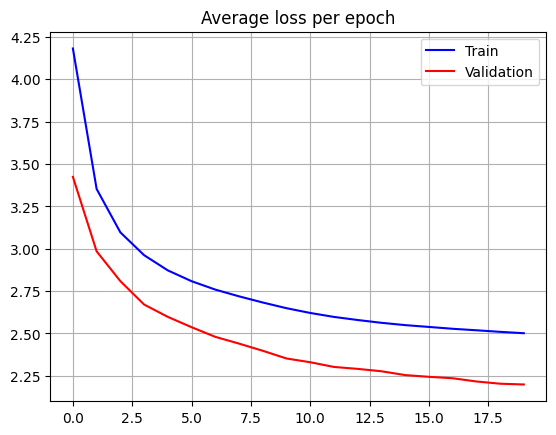

In [31]:
plt.plot(train_losses, color="blue", label="Train")
plt.plot(valid_losses, color="red", label="Validation")
plt.legend()
plt.grid()
plt.title("Average loss per epoch")

### Evaluate

In [51]:
translator.load_state_dict(torch.load(f"{PARENT_DIR}/models/{model_name}_bestval.pt", map_location=device))
translator.eval()

TranslatorModel(
  (encoder): Encoder(
    (token_embedding): Embedding(4000, 256)
    (positional_embedding): Embedding(128, 256)
    (dropout): Dropout(p=0.3, inplace=False)
    (layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (norm_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (ff): PositionWiseFeedForward(
          (fc_1): Linear(in_features=256, out_features=1024, bias=True)
          (fc_2): Linear(in_features=1024, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (mha): MultiHeadAttention(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (out): Linear(in_features=256, out_features=256, bias=True)
          (d

In [60]:
random_eval_idx = int(np.random.choice(list(range(len(train_data)))))
print_sentences(data=train_data, idx=random_eval_idx, model=translator, src_lang=src_lang, tgt_lang=tgt_lang, device=device)

SOURCE: vor einigen jahren saß ich in einem flugzeug auf dem weg zur ostküste, und der mann in der reihe neben mir war der bürgermeister von charlotte, north carolina.
TARGET: but i was on an airplane in the east some years ago, and the man sitting across the aisle from me was the mayor of charlotte, north carolina.
MODEL: a a sat sitting a airplane on a east coast years ago, and the man in in the series seriespher of char, the mayor of charlotte, north carolina. <EOS> cart


In [61]:
idxs = [42, 422, 10, 7, 999]

for idx in idxs:
    print_sentences(data=train_data, idx=idx, model=translator, src_lang=src_lang, tgt_lang=tgt_lang, device=device)
    print("-" * 100)

SOURCE: ein wort zur diashow. ich aktualisiere sie jedes mal, bevor ich sie zeige.
TARGET: now, the slide show. i update the slide show every time i give it.
MODEL: a, a wordsh. i ' everyate them di every you time before show you. <EOS> show
----------------------------------------------------------------------------------------------------
SOURCE: sehen sie sich das an -- die dünne schwarze linie ist die höchste geschwindigkeit, mit der wir je geflogen sind. und die rote line, das sind die schnellsten militärjets und die blaue linie steht für die kommerzielle luftfahrt.
TARGET: if you look at what happened -- this little black line is as fast as man ever flew, and the red line is top - of - the - line military fighters and the blue line is commercial air transport.
MODEL: look you look at this -- -- the is black line is the theest we, flew, and the red line is the of line - line - line military projects and the blue line is the air travelation <EOS> blue
--------------------------

In [62]:
bleu = evaluate.load("bleu")

def get_tokenizer_fn(tgt_tokenizer: Tokenizer):
    def tokenizer_fn(s):
        tokens = tgt_tokenizer.encode(s).tokens
        return tokens

    return tokenizer_fn

tokenizer_fn = get_tokenizer_fn(tgt_lang)

In [63]:
# compute BLEU metric on test data
predictions, references = [], []
for idx in tqdm(range(test_data.num_rows)):
    data_eval_src = test_data[idx]["de_ids"].reshape(1, -1).to(device)
    sentence_evaluated = translate(model=translator,
                                   src=data_eval_src,
                                   src_lang=src_lang,
                                   tgt_lang=tgt_lang,
                                   max_tgt_length=max_length,
                                   device=device,
                                   clean=True)


    predictions.append(sentence_evaluated)
    references.append(test_data[idx]["translation"]["en"])

bleu.compute(predictions=predictions, references=references, tokenizer=tokenizer_fn)

100%|██████████| 8079/8079 [06:37<00:00, 20.35it/s]


{'bleu': 0.3048373443181313,
 'precisions': [0.6653356099985951,
  0.420663664562934,
  0.2674592085632415,
  0.18063284606631888],
 'brevity_penalty': 0.8939447068629103,
 'length_ratio': 0.8991905312563772,
 'translation_length': 185066,
 'reference_length': 205814}